## Data access demo!

In [2]:
from dask.distributed import Client
from rasterio.enums import Resampling
import stackstac
import pystac_client
import warnings
warnings.filterwarnings('ignore')

Instantiate a local dask client. This will execute your dask-parallelised code locally and can be replaced by a larger, remotely-hosted client when more power is necessary!

In [3]:
client = Client()
client

2022-12-07 19:14:01,916 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-xzy1fyo4', purging
2022-12-07 19:14:01,919 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-u93d_yys', purging
2022-12-07 19:14:01,920 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-kwxw464c', purging
2022-12-07 19:14:01,922 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-31zdv7ru', purging


<Client: 'tcp://127.0.0.1:42713' processes=4 threads=12, memory=7.39 GiB>

## Lazy data loading with STAC!

Search a STAC catalogue for relevant items. This element84 catalogue is just an example, the data you need to load might be exposed through on an EODC-hosted catalogue.

In this case we're searching this catalogue for items that contain data that 
- comes from the sentinel-s2-l2a-cogs collection
- intersects the point (-106, 35.7)
- is from 2019-05-01 to 2019-06-01

In [4]:
# This will be something like api.eodc.eu/stac
items = pystac_client.Client.open(
    "https://earth-search.aws.element84.com/v0"
).search(
    intersects=dict(type="Point", coordinates=[-106, 35.7]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2019-05-01/2019-06-01",
    limit=1000
).get_all_items()
len(items)

28

There are 28 STAC items that fit this description. The next step is to load them into an `xarray.DataArray`. This uses the STAC items to construct a datacube! Note that the underlying data has not actually been loaded yet. Rather, a lazily evaluated, chunked dask array has been constructed to represent this dataset. Having this datacube in dask allows us to distribute computations on this datacube over a cluster of worker nodes.  

In [5]:
items

In [6]:
stack = stackstac.stack(
    items,
    resolution=100,
    bounds_latlon=(-106.2, 35.9, -106.1, 36),
    resampling=Resampling.bilinear
);stack

<xarray.DataArray 'stackstac-248ccad9e28258b178a3252398a9bc36' (time: 28,
                                                                band: 17,
                                                                y: 113, x: 92)>
dask.array<fetch_raster_window, shape=(28, 17, 113, 92), dtype=float64, chunksize=(1, 1, 113, 92), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                        (time) datetime64[ns] 2019-05-02T18:04:10 ......
    id                          (time) <U24 'S2A_13SDV_20190502_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'B11' ... 'visual' 'SCL'
  * x                           (x) float64 3.917e+05 3.918e+05 ... 4.008e+05
  * y                           (y) float64 3.985e+06 3.985e+06 ... 3.974e+06
    view:off_nadir              int64 0
    ...                          ...
    eo:cloud_cover              (time) float64 1.73 1.97 3.01 ... 59.4 26.49
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    common_name                 (band) object None 'swir16' ... None None
    center_wavelength           (band) object None 1.6137 0.4439 ... None None
    full_width_half_max         (band) object None 0.143 0.027 ... None None
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(391700, 3973400, 400900, 3984...
    crs:         epsg:32613
    transform:   | 100.00, 0.00, 391700.00|\n| 0.00,-100.00, 3984700.00|\n| 0...
    resolution:  100

Here we're just doing a little dummy computation - selecting the RGB bands and resampling the time dimension to months to then compute a monthly median. 

In [7]:
rgb = stack.sel(band=["B04", "B03", "B02"])
monthly_rgb = rgb.resample(time="MS").median(dim="time")
monthly_rgb

<xarray.DataArray 'stackstac-248ccad9e28258b178a3252398a9bc36' (time: 2,
                                                                band: 3,
                                                                y: 113, x: 92)>
dask.array<stack, shape=(2, 3, 113, 92), dtype=float64, chunksize=(1, 3, 113, 92), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * band                    (band) <U8 'B04' 'B03' 'B02'
  * x                       (x) float64 3.917e+05 3.918e+05 ... 4.008e+05
  * y                       (y) float64 3.985e+06 3.985e+06 ... 3.974e+06
    view:off_nadir          int64 0
    constellation           <U10 'sentinel-2'
    gsd                     (band) object 10 10 10
    ...                      ...
    title                   (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name             (band) object 'red' 'green' 'blue'
    center_wavelength       (band) object 0.6645 0.56 0.4966
    full_width_half_max     (band) object 0.038 0.045 0.098
    epsg                    int64 32613
  * time                    (time) datetime64[ns] 2019-05-01 2019-06-01
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(391700, 3973400, 400900, 3984...
    crs:         epsg:32613
    transform:   | 100.00, 0.00, 391700.00|\n| 0.00,-100.00, 3984700.00|\n| 0...
    resolution:  100

This has still not actually done any data loading or computation, but the xarray (or actually the underlying dask task graph) now holds a lazy representation of what would need to be done in order to execute this computation.

We can force this lazy expression to evaluate using `.compute()`. This is quite slow here, because we don't have priviledged access to element84's data. Doing this on data hosted at EODC from an EODC hosted dask cluster would be much much faster, because of fast network interconnects!

In [8]:
rgb_ = monthly_rgb.compute()

In [9]:
rgb_

<xarray.DataArray 'stackstac-248ccad9e28258b178a3252398a9bc36' (time: 2,
                                                                band: 3,
                                                                y: 113, x: 92)>
array([[[[2822. , 2356. , 1989. , ..., 1838. , 1929. , 1967.5],
         [3037. , 2716. , 2332. , ..., 1780. , 1836.5, 1916.5],
         [2284. , 2177. , 2125. , ..., 2210.5, 2118. , 2329. ],
         ...,
         [1504. , 1371. , 1329. , ..., 2467. , 2514.5, 2325. ],
         [2022. , 1678. , 1398. , ..., 2757. , 2414.5, 2180. ],
         [1948. , 2012. , 1584. , ..., 2823. , 2304.5, 2415. ]],

        [[2767. , 2251. , 1818. , ..., 1549.5, 1602.5, 1649. ],
         [2781. , 2354. , 1922. , ..., 1508.5, 1529.5, 1657. ],
         [1855. , 1719. , 1700. , ..., 1841. , 1722.5, 1918. ],
         ...,
         [1333. , 1237. , 1222. , ..., 1945.5, 1995.5, 1856. ],
         [1568. , 1406. , 1221. , ..., 2176. , 1920.5, 1738.5],
         [1526. , 1582. , 1288. , ..., 2187. , 1817. , 1887.5]],

        [[2823. , 2207. , 1695. , ..., 1220.5, 1243. , 1368.5],
         [2544. , 1999. , 1570. , ..., 1247. , 1281.5, 1695.5],
         [1529. , 1374. , 1379. , ..., 1427.5, 1805. , 1514. ],
         ...,
...
         ...,
         [1342. , 1218. , 1176. , ..., 2258. , 2296.5, 2125. ],
         [1760. , 1554. , 1241. , ..., 2520. , 2178. , 2036. ],
         [1617. , 1769. , 1467. , ..., 2553. , 2082. , 2183.5]],

        [[ 950. ,  557. ,  327. , ..., 1411. , 1443. , 1491.5],
         [ 869. ,  489. ,  407. , ..., 1362. , 1370. , 1418. ],
         [1101. ,  595. ,  398. , ..., 1623. , 1555. , 1481.5],
         ...,
         [1132. , 1061. , 1039. , ..., 1766.5, 1809. , 1690.5],
         [1353. , 1257. , 1078. , ..., 1973. , 1727. , 1608. ],
         [1252. , 1356. , 1175. , ..., 1959.5, 1641.5, 1700. ]],

        [[ 689. ,  407. ,  245. , ..., 1072. , 1089.5, 1145. ],
         [ 659. ,  373. ,  304. , ..., 1010. , 1023. , 1058. ],
         [ 814. ,  456. ,  299. , ..., 1182.5, 1120.5, 1082. ],
         ...,
         [ 863. ,  819. ,  794. , ..., 1320.5, 1365. , 1267.5],
         [ 965. ,  937. ,  829. , ..., 1506. , 1301.5, 1201. ],
         [ 907. ,  972. ,  871. , ..., 1478.5, 1223.5, 1258.5]]]])
Coordinates: (12/16)
  * band                    (band) <U8 'B04' 'B03' 'B02'
  * x                       (x) float64 3.917e+05 3.918e+05 ... 4.008e+05
  * y                       (y) float64 3.985e+06 3.985e+06 ... 3.974e+06
    view:off_nadir          int64 0
    constellation           <U10 'sentinel-2'
    gsd                     (band) object 10 10 10
    ...                      ...
    title                   (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name             (band) object 'red' 'green' 'blue'
    center_wavelength       (band) object 0.6645 0.56 0.4966
    full_width_half_max     (band) object 0.038 0.045 0.098
    epsg                    int64 32613
  * time                    (time) datetime64[ns] 2019-05-01 2019-06-01
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(391700, 3973400, 400900, 3984...
    crs:         epsg:32613
    transform:   | 100.00, 0.00, 391700.00|\n| 0.00,-100.00, 3984700.00|\n| 0...
    resolution:  100

Now you can do whatever you want to with this computed data, e.g. plot!

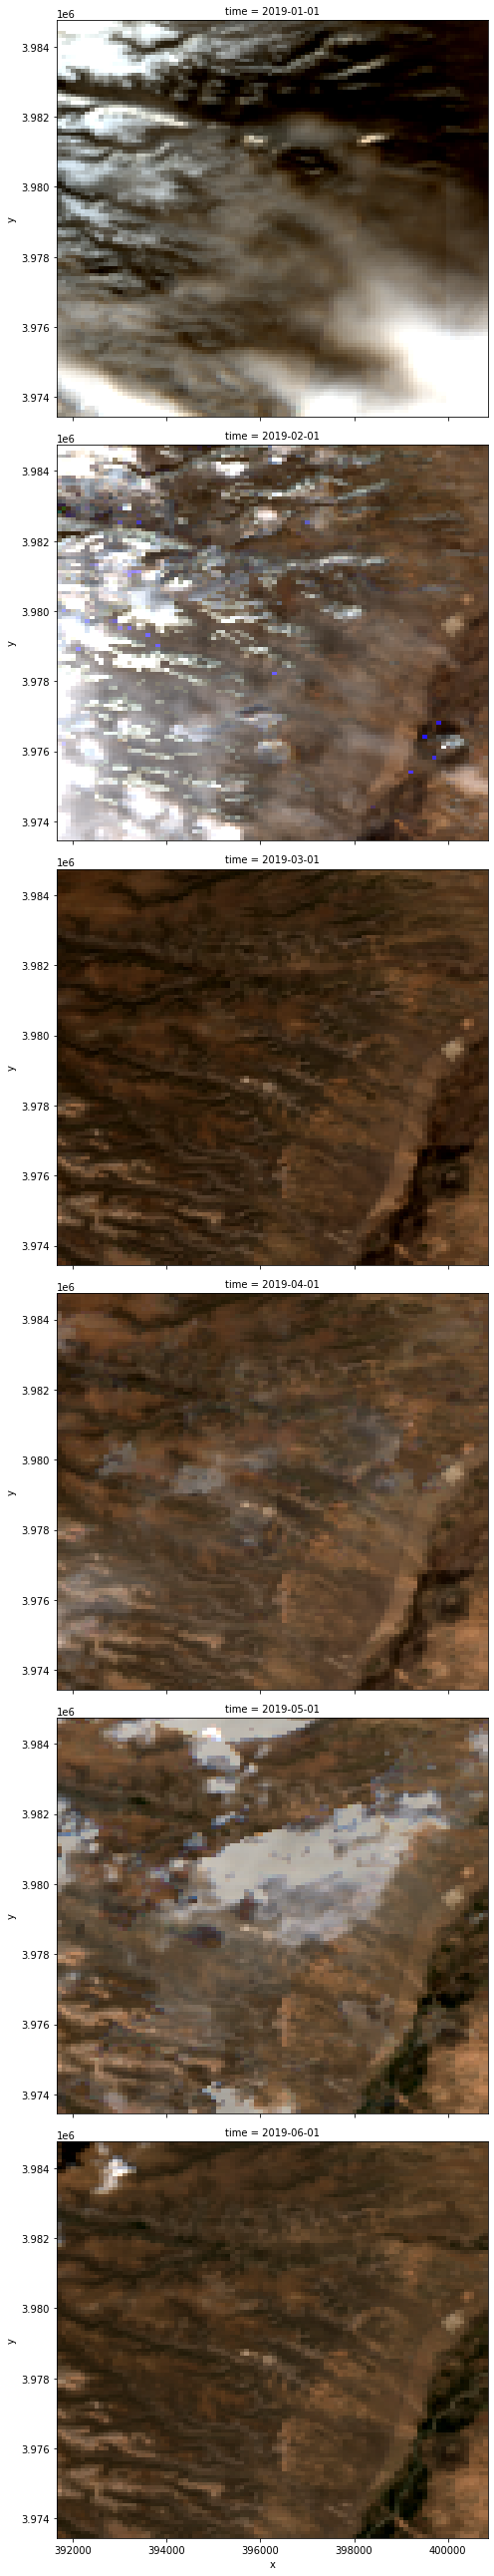

In [11]:
rgb_.plot.imshow(row="time", rgb="band", robust=True, size=6)

## Attaching to remote clusters using Dask Gateway

When its time to scale up this analysis (dataset doesn't fit into memory or just want speedup), connect to a larger remotely hosted Dask cluster with dask gateway.

In [ ]:
DASK_GATEWAY_URL = None

In [ ]:
from dask_gateway import Gateway

gateway = Gateway(DASK_GATEWAY_URL)
cluster = gateway.new_cluster()
# Alternatively connect to an existing cluster with:
# clusters = gateway.list_clusters()
# cluster = gateway.connect(clusters[0].name)
cluster.scale(2)
client = cluster.get_client()
client